In [651]:
import math
import os
import seaborn as sns

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal
from scipy.stats import rv_discrete


In [559]:
def get_jain_index(resources):
    """Calculates the Jain index of a list of resources."""

    # Jain fairness index
    # index close to 1 means fair distribution of resources
    # index close to 1/n means unfait distribution of resources

    n = resources.shape[0]
    r = resources

    if n <= 1:
        return 1.0
    else:
        return ((np.sum(r) ** 2) / (np.sum(r ** 2) * n))
    

def get_jain_index_max(np, nc):
    """Calculates the maximum possible value of the Jain index."""
    x = nc/np
    d = x - int(x)
    index = (1 + d*(1-d)/(x*x))**-1
    return index

In [591]:
# Identify which device should be used by torch for the ANN calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class AgentNet(nn.Module):
    def __init__(self, n_players, n_coins):
        super(AgentNet, self).__init__()
        self.n_players = n_players
        self.n_coins = n_coins
        self.n_actions = 2 # 0 non do soldi, 1 do soldi
        h_size = int(n_coins)
        a_size = self.n_actions
        self.fc1 = nn.Linear(n_coins+1, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.epsilon = 0.1

    def forward(self, x): #entrata: n coins che ho
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)

        n = out.size()
        mask = torch.zeros(n).to(device)

        return out

    def act(self, state): # state = my_coins

        state = torch.from_numpy(state).unsqueeze(dim=0).to(device)#.float().unsqueeze(0).to(device)
        #print("state=", state)
        state = F.one_hot(state, num_classes=self.n_coins+1).float()#.long() #to(torch.long)#.type(torch.LongTensor)
        #print("state=", state)
        #print("type=", state.dtype)

        probs_total = self.forward(state).cpu()
        #print("probs_total=", probs_total)

        #probs_total = probs_total.view([-1, self.n_players])
        #print("probs_total=", probs_total)
        probs_total = F.softmax(probs_total, dim=1)
        #print("probs_total=", probs_total)
        
        m = Categorical(probs_total)

        if np.random.rand() < self.epsilon:
            #proba = get_probs(self.n_players, self.n_coins, decider_rank)
            uniform = Categorical(probs_total)
            action = uniform.sample()
        else:
            action = m.sample()

        return action, m.log_prob(action), probs_total

In [498]:
n_players = 3
n_coins = 15
my_coins = np.array((3))
ag = AgentNet(n_players = n_players, n_coins = n_coins)
ag.act(my_coins)

state= tensor([3])


(tensor([0]), tensor([-0.6432], grad_fn=<SqueezeBackward1>))

In [662]:
class Environment:

    def __init__(self, n_players, n_total_coins, threshold = 0., multiplier = 1.):
        self.n_players = n_players
        self.coins = n_total_coins
        self.state = np.zeros((self.n_players,1))
        self.threshold = threshold
        self.multiplier = multiplier

    def reset(self):
        self.state = np.zeros(self.n_players)
            
    def sample(self):
        coins = self.coins
        #print("total coins=", coins)
        
        for i in range(self.n_players):
            if (i == self.n_players - 1):
                self.state[i] = coins
                #print("self.state[",i,"]=", self.state[i])
            else:
                self.state[i] = int(np.random.choice(coins-1, 1))
                #print("self.state[",i,"]=", self.state[i])
                coins = coins - int(self.state[i])
                #print("new coins=", coins)
                
                
        return self.state

    def step(self, coins, actions):
        rewards = np.zeros(self.n_players)
        
        if (np.sum(actions)) < self.threshold:
            return rewards
        
        amount = np.sum([coins[i] for i in range(self.n_players) if actions[i] == 1])
            
        for i in range(self.n_players):
            if (actions[i] == 1.):
                rewards[i] = amount/self.n_players*self.multiplier
            else:
                rewards[i] = amount/self.n_players*self.multiplier + coins[i]
                
            # trick to avoid log(0) 
            if rewards[i] <= 0:
                rewards[i] = 1e-6

        return rewards

In [663]:
def reinforce_players(n_players=5, n_coins=10, n_episodes=1, print_every=1, threshold=0., multiplier=1.):
    torch.autograd.set_detect_anomaly(True)
    
    env = Environment(n_players, n_coins, threshold, multiplier)
    
    agents = {}
    opts = {}
    for i in range(n_players):
        agents[i] = AgentNet(n_players, n_coins)
        opts[i] = optim.Adam(agents[i].parameters(), lr=0.01)
    
    history = {
        "loss": [],
        "mean_rew":[],
        "jain_idx":[]
    }
    
    history_rewards = {
        "rew_0": [],
        "rew_1": [],
        "rew_2": []
    }

    for e in range(n_episodes):

        agents_log_probs = [[] for _ in range(n_players)]
        agents_rewards = [[] for _ in range(n_players)]
        
        env.reset()
        coins = env.sample()
        #print("Coins=", coins)
        actions = []
        log_probs = []

        for agent_idx, ag in agents.items():

            a, log_prob, _ = ag.act(np.array(int(coins[agent_idx])))
            actions.append(a.detach().numpy())
            log_probs.append(log_prob)
             
        rewards = env.step(coins, actions)
        for idx, r in enumerate(rewards):
            history_rewards["rew_"+str(idx)].append(rewards[idx])
        #print("rewards=", rewards)
        #print("log probs=", log_probs)
        
        losses = []
        for rew, log_prob in zip(rewards, log_probs):
            losses.append(-log_prob*rew)
            
        history["loss"].append(np.mean([l.detach().numpy() for l in losses]))       
        history["mean_rew"].append(np.mean(rewards))
        history["jain_idx"].append(get_jain_index(rewards))
                    
        for idx, loss in enumerate(losses):
            #if (idx == 0):
            #print("loss=", loss)
            opts[idx].zero_grad()
            loss.backward()
            opts[idx].step()
            
        if (e%100 == 0):
            print("\nEpisode=", e)
            temp=[l.detach().numpy() for l in losses]
            print("losses=", np.mean(temp))
            
    return history, agents, history_rewards

In [696]:
n_episodes = 3000

n_players = 3
n_coins = 10

threshold = 0.
multiplier = float(n_players)/2.+3.

history, agents, hr = reinforce_players(n_players=n_players, n_coins=n_coins, n_episodes=n_episodes, threshold = threshold, multiplier=multiplier)


Episode= 0
losses= 2.1119697

Episode= 100
losses= 10.379967

Episode= 200
losses= 6.35

Episode= 300
losses= 3.76069

Episode= 400
losses= 5.20121

Episode= 500
losses= 2.594937

Episode= 600
losses= 1.2205714

Episode= 700
losses= 4.804342

Episode= 800
losses= 2.3778267

Episode= 900
losses= 7.1167545

Episode= 1000
losses= 1.7917887

Episode= 1100
losses= 0.42139795

Episode= 1200
losses= 0.036362622

Episode= 1300
losses= 0.7259832

Episode= 1400
losses= 0.01955346

Episode= 1500
losses= 0.020891929

Episode= 1600
losses= 0.0029782497

Episode= 1700
losses= 0.002804391

Episode= 1800
losses= 0.0021174566

Episode= 1900
losses= 0.0057628737

Episode= 2000
losses= 0.009652588

Episode= 2100
losses= 0.002358008

Episode= 2200
losses= 0.0068553686

Episode= 2300
losses= 0.0029439067

Episode= 2400
losses= 0.00070278003

Episode= 2500
losses= 0.0021038237

Episode= 2600
losses= 0.00083899574

Episode= 2700
losses= 0.00051291526

Episode= 2800
losses= 0.0065137446

Episode= 2900
losses

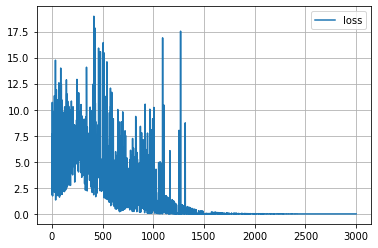

In [697]:
plt.plot(np.linspace(0, n_episodes, n_episodes), history["loss"], label='loss')
plt.legend()
plt.grid()
plt.show()

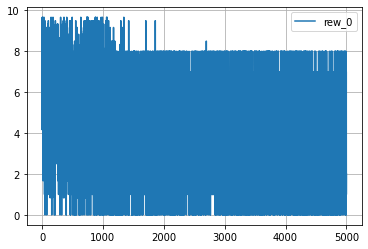

In [692]:
plt.plot(np.linspace(0, n_episodes, n_episodes), hr["rew_0"], label='rew_0')
#plt.plot(np.linspace(0, n_episodes, n_episodes), hr["rew_1"], label='rew_1')
plt.legend()
plt.grid()
plt.show()

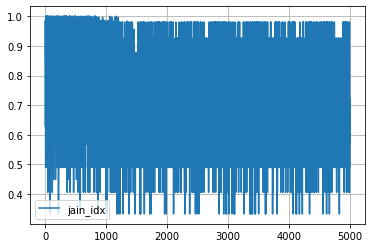

In [693]:
plt.plot(np.linspace(0, n_episodes, n_episodes), history["jain_idx"], label='jain_idx')
plt.legend()
plt.grid()
plt.show()

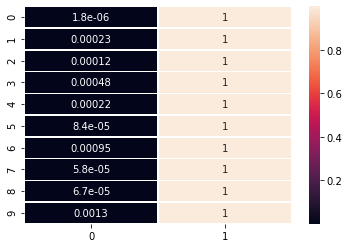

In [698]:
probbs = np.zeros((n_coins, 2))

for c in range(n_coins):
    a, log_prob, probs = agents[0].act(np.array(c))
    probbs[c] = probs.detach().numpy()
    
ax = sns.heatmap(probbs, annot=True, linewidth=.5)

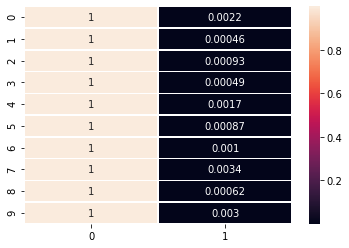

In [673]:
probbs = np.zeros((n_coins, 2))

for c in range(n_coins):
    a, log_prob, probs = agents[0].act(np.array(c))
    probbs[c] = probs.detach().numpy()
    
ax = sns.heatmap(probbs, annot=True, linewidth=.5)

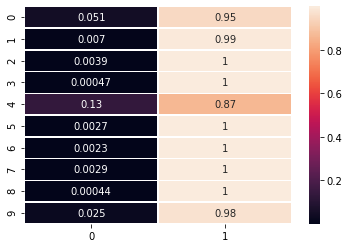

In [668]:
probbs = np.zeros((n_coins, 2))

for c in range(n_coins):
    a, log_prob, probs = agents[0].act(np.array(c))
    probbs[c] = probs.detach().numpy()
    
ax = sns.heatmap(probbs, annot=True, linewidth=.5)